In [1]:
# Setup
import os
import sys
from pathlib import Path

if Path.cwd().name == 'two_populations':
    os.chdir('../..')

import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
from datetime import datetime
import json
from scipy.signal import correlate, correlation_lags, welch

# Parallel execution
from joblib import Parallel, delayed
from tqdm import tqdm
import multiprocessing as mp
import warnings

from src.two_populations.model import IzhikevichNetwork
from src.two_populations.metrics import analyze_simulation_results, voltage_to_lfp, cross_correlation_analysis, power_spectrum_analysis
from src.two_populations.plots.basic_plots import plot_raster_results
from src.two_populations.plots.dashboard_plots import plot_population_dashboard, plot_connectivity_dashboard, plot_spectrogram
from src.two_populations.helpers.logger import setup_logger

from src.two_populations.plots.basic_plots import plot_raster_results, plot_voltage_traces
from src.two_populations.plots.dashboard_plots import plot_population_dashboard, plot_connectivity_dashboard, plot_spectrogram, plot_palmigiano_dashboard
from src.two_populations.metrics import palmigiano_analysis
from src.two_populations.metrics import print_network_statistics_table

from joblib import Parallel, delayed
from tqdm import tqdm
import multiprocessing as mp
import warnings
import os

from src.two_populations.helpers.validator import (
    add_validation_to_analysis, 
    plot_population_validation_dashboard, 
    print_validation_summary
)


logger = setup_logger(
    experiment_name="spike_propagation",
    console_level="INFO",
    file_level="DEBUG",
    log_to_file=False
)

logger.info(f"Working directory: {Path.cwd()}")

/home/ubuntu-deduce/Projects/izhikevich/.venv/lib/python3.10/site-packages/setuptools/_distutils/_msvccompiler.py:12: UserWarning: _get_vc_env is private; find an alternative (pypa/distutils#340)
  warnings.warn(
INFO       Cache size for target 'cython': 2791 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the '/home/ubuntu-deduce/.cython/brian_extensions' directory. [brian2]
INFO     | __main__:<module>:53 - Working directory: /home/ubuntu-deduce/Projects/izhikevich


In [34]:
from src.two_populations.model import IzhikevichNetwork
import numpy as np
from src.two_populations.model import IzhikevichNetwork
from src.two_populations.metrics import analyze_simulation_results, print_network_statistics_table
from src.two_populations.plots.dashboard_plots import plot_connectivity_dashboard, plot_population_dashboard
from brian2 import * 
from src.two_populations.metrics import analyze_simulation_results

# =============================================================================
# SINGLE SIMULATION CONFIGURATION
# =============================================================================

k_factor = 19.0
intra_delay = 0.0
p_intra = 0.1
Ni = 200
Ne = 800
time = 2500

# Simulation parameters
SIM_CONFIG = {
    'dt_ms': 0.1,
    'T_ms': time,
    'warmup_ms': 500
}

# Network parameters
NETWORK_PARAMS = {
    'pop_A': {
        'Ne': Ne, 'Ni': Ni,
        'k_exc': k_factor, 'k_inh': k_factor*3.9,
        'noise_exc': 0.884, 
        'noise_inh': 0.60,
        'p_intra': 0.1, 
        'delay': 0.0,
        'rate_hz':10.1,
        'stim_start_ms':1.0, 'stim_duration_ms': 500.0,
        'stim_base': 0.01, 
        'stim_elevated': 0.7
    }
}


logger.info("Simulation configured:")
logger.info(f"  Duration: {SIM_CONFIG['T_ms']}ms, dt: {SIM_CONFIG['dt_ms']}ms")

# =============================================================================
# RUN SINGLE SIMULATION
# =============================================================================

start_scope()

# Create network
network = IzhikevichNetwork(
    dt_val=SIM_CONFIG['dt_ms'],
    T_total=SIM_CONFIG['T_ms'],
    fixed_seed=100,
    variable_seed=200,
    trial=1
)

pop_A = network.create_population2(name='A', **NETWORK_PARAMS['pop_A'])

# Setup monitors and run
network.setup_monitors(['A'], record_v_dt=0.5, sample_fraction=0.5)
results = network.run_simulation()

# Quick check
logger.info(f"\n{'='*50}")
logger.info("SIMULATION COMPLETED")
logger.info(f"{'='*50}")
logger.info(f"Population A: {len(results['A']['spike_times'])} spikes")
logger.info(f"Recording shape: {results['A']['potentials'].shape}")

# =============================================================================
# ANALYSIS WITH VALIDATION
# =============================================================================

# Analyze connectivity
results_dict = {
    'baseline': analyze_simulation_results(
        spike_mon_A = results['A']['spike_monitor'], 
        spike_mon_B = None,  
        N = Ne + Ni, 
        condition_name="test",
        warmup=SIM_CONFIG['warmup_ms'],
        state_monitors={'A': network.monitors['A']},
        delays=None, 
        signal_mode='lfp',
        T_total=SIM_CONFIG['T_ms']
    )
}

INFO       Simulation configured: [brian2]
INFO         Duration: 2500ms, dt: 0.1ms [brian2]
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}


INFO     | src.two_populations.model:_create_stimulus2:290 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:352 - PoissonGroup A: 100 sources @ 10.1Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:267 - Population A (PoissonInput): 800E/200I, 79872+20190 syn
INFO       
================================================== [brian2]
INFO       SIMULATION COMPLETED [brian2]
INFO       ================================================== [brian2]
INFO       Population A: 46856 spikes [brian2]
INFO       Recording shape: (500, 5000) [brian2]
INFO     | src.two_populations.metrics:analyze_simulation_results:562 - 
=== test (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:569 - Single population analysis
INFO     | src.two_populations.metrics:analyze_simulation_results:570 - Timescale A: 6.2ms


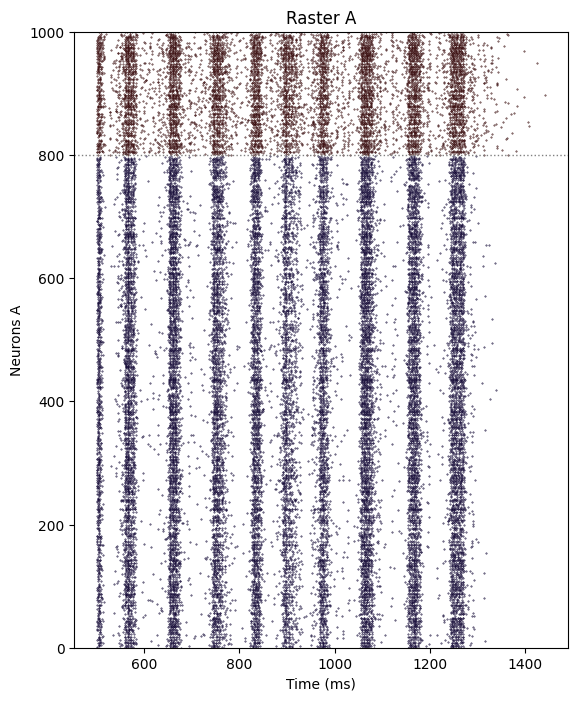

In [35]:
fig = plot_raster_results(results)

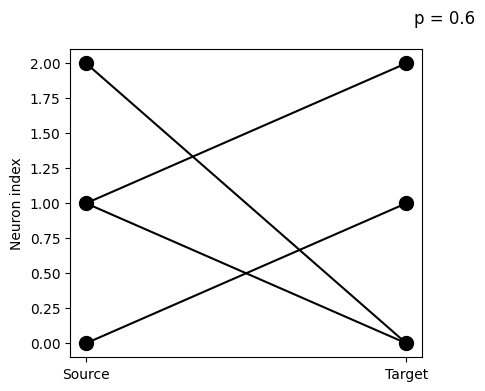

In [4]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
        xticks([0, 1], ['Source', 'Target'])
        ylabel('Neuron index')


start_scope()
N = 3
G = NeuronGroup(N, 'v:1')
for p in [0.6]:
    S = Synapses(G, G)
    S.connect(condition='i!=j', p=p)
    visualise_connectivity(S)
    suptitle('p = '+str(p))


WARNING    The object 'synapses_3' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/tmp/ipykernel_14236/1616252964.py', line 18, in <module>
    S = Synapses(G, G) [brian2.core.base.unused_brian_object]


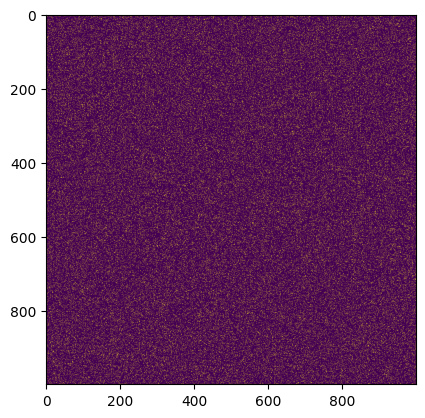

In [5]:
matt = np.zeros((1000, 1000))
S = network.populations['A']['syn_intra']
for i, j in zip(S.i, S.j):
    matt[i, j] = 1

plt.imshow(matt)

(array([8103., 7903., 8031., 7843., 7973., 7978., 8122., 7912., 7938.,
        8069.]),
 array([4.69796739e-06, 5.00002126e-01, 9.99999555e-01, 1.49999698e+00,
        1.99999441e+00, 2.49999184e+00, 2.99998927e+00, 3.49998670e+00,
        3.99998413e+00, 4.49998155e+00, 4.99997898e+00]),
 <BarContainer object of 10 artists>)

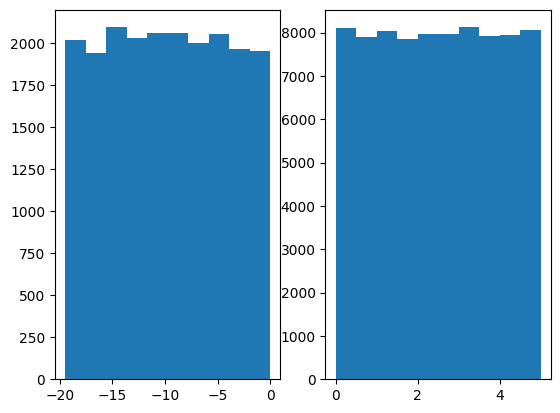

In [6]:
S = network.populations['A']['syn_intra']

plt.subplot(121)
plt.hist(np.array(S.w)[np.array(S.w)<0])
plt.subplot(122)
plt.hist(np.array(S.w)[np.array(S.w)>0])

In [7]:
S = network.populations['A']['syn_intra']
connections = []

for i, j in zip(S.i, S.j):
    connections.append((i,j))
    
connections

[(np.int32(0), np.int32(3)),
 (np.int32(0), np.int32(10)),
 (np.int32(0), np.int32(12)),
 (np.int32(0), np.int32(45)),
 (np.int32(0), np.int32(48)),
 (np.int32(0), np.int32(54)),
 (np.int32(0), np.int32(66)),
 (np.int32(0), np.int32(96)),
 (np.int32(0), np.int32(97)),
 (np.int32(0), np.int32(145)),
 (np.int32(0), np.int32(148)),
 (np.int32(0), np.int32(151)),
 (np.int32(0), np.int32(161)),
 (np.int32(0), np.int32(168)),
 (np.int32(0), np.int32(169)),
 (np.int32(0), np.int32(178)),
 (np.int32(0), np.int32(179)),
 (np.int32(0), np.int32(186)),
 (np.int32(0), np.int32(209)),
 (np.int32(0), np.int32(211)),
 (np.int32(0), np.int32(226)),
 (np.int32(0), np.int32(232)),
 (np.int32(0), np.int32(244)),
 (np.int32(0), np.int32(246)),
 (np.int32(0), np.int32(248)),
 (np.int32(0), np.int32(263)),
 (np.int32(0), np.int32(268)),
 (np.int32(0), np.int32(291)),
 (np.int32(0), np.int32(300)),
 (np.int32(0), np.int32(323)),
 (np.int32(0), np.int32(342)),
 (np.int32(0), np.int32(357)),
 (np.int32(0), np.

Total spikes E→E causales detectados: 4679
Total spikes en la red: 7141
Porcentaje de spikes causales: 65.52%


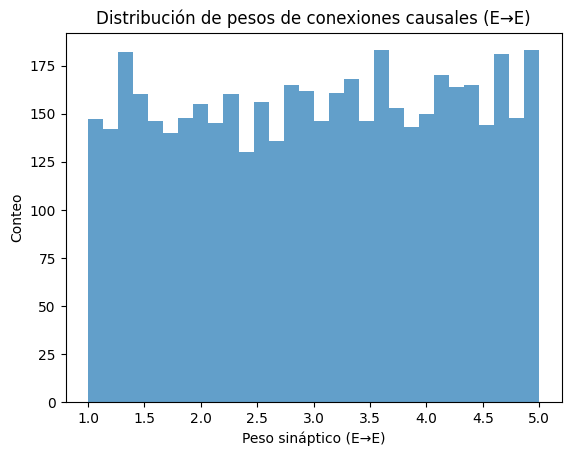

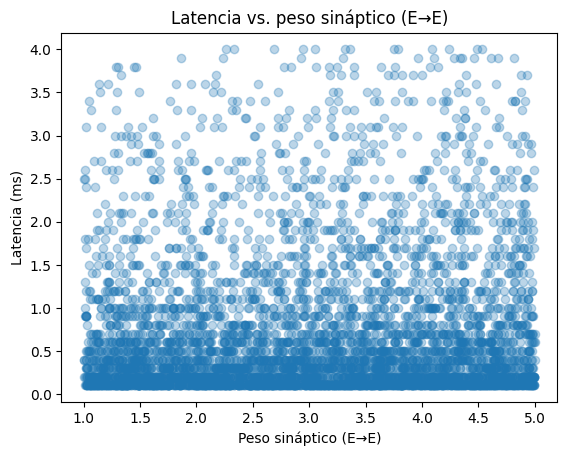

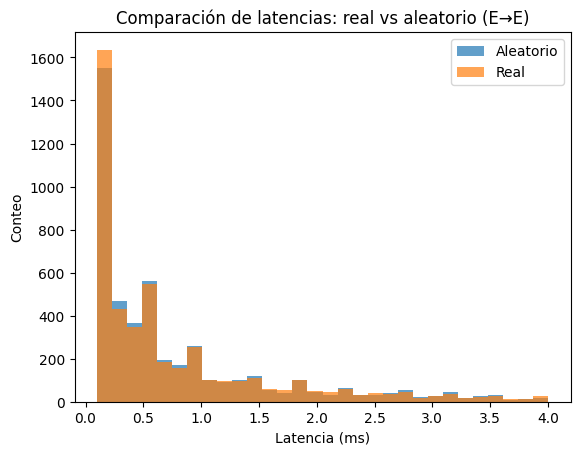

In [8]:
# Solo analizar conexiones excitatorias (E→E)
import numpy as np

S = network.populations['A']['syn_intra']
Ne = network.populations['A']['Ne']
Ni = network.populations['A']['Ni']
N_total = Ne + Ni

def pick_exc_neighbors(syn_intra, post_id, min_weight=0.0, Ne=800):
    i_arr = np.array(syn_intra.i)
    j_arr = np.array(syn_intra.j)
    w_arr = np.array(syn_intra.w)
    # Solo presinápticos excitatorios (índice < Ne y peso > 0)
    mask = (j_arr == post_id) & (i_arr < Ne) & (w_arr > min_weight)
    return i_arr[mask]

spike_times = results['A']['spike_times']
spike_neurons = results['A']['spike_indices']

warmup_ms = 500
spike_mask = spike_times > warmup_ms
spike_times = spike_times[spike_mask]
spike_neurons = spike_neurons[spike_mask]

window_ms = 4.0 # depende del decay temporal de la sinapsis
min_latency_ms = 0.0 # depende del delay de la sinapsis
causal_spikes = []

for post_id in range(Ne):  # Solo postsinápticas excitatorias
    pres_ids = pick_exc_neighbors(S, post_id, min_weight=1.0, Ne=Ne)
    post_times = spike_times[spike_neurons == post_id]
    for t_post in post_times:
        t_pres_candidates = []
        for pres_id in pres_ids:
            if pres_id == post_id:
                continue
            pres_times = spike_times[spike_neurons == pres_id]
            pres_in_window = pres_times[(pres_times < t_post) & (pres_times >= t_post - window_ms)]
            if len(pres_in_window) > 0:
                t_pres = pres_in_window[-1]
                latency = t_post - t_pres
                if latency >= min_latency_ms:
                    t_pres_candidates.append((pres_id, t_pres, latency))
        if len(t_pres_candidates) > 0:
            pres_id, t_pres, latency = min(t_pres_candidates, key=lambda x: x[2])
            causal_spikes.append({
                'pres_id': int(pres_id),
                'post_id': int(post_id),
                't_pres': float(t_pres),
                't_post': float(t_post),
                'latency_ms': float(latency)
            })

# ...código causal_spikes...

print(f"Total spikes E→E causales detectados: {len(causal_spikes)}")
print(f"Total spikes en la red: {len(spike_times)}")
print(f"Porcentaje de spikes causales: {100 * len(causal_spikes) / len(spike_times):.2f}%")

import pandas as pd
df_causal = pd.DataFrame(causal_spikes)

# Añadir el peso sináptico de cada conexión causal
i_arr = np.array(S.i)
j_arr = np.array(S.j)
w_arr = np.array(S.w)
def get_weight(pre, post):
    mask = (i_arr == pre) & (j_arr == post)
    return w_arr[mask][0] if np.any(mask) else np.nan
df_causal['weight'] = df_causal.apply(lambda row: get_weight(row['pres_id'], row['post_id']), axis=1)

# Histograma de pesos de conexiones causales
plt.figure()
plt.hist(df_causal['weight'], bins=30, alpha=0.7)
plt.xlabel('Peso sináptico (E→E)')
plt.ylabel('Conteo')
plt.title('Distribución de pesos de conexiones causales (E→E)')
plt.show()

# Scatter plot latencia vs peso
plt.figure()
plt.scatter(df_causal['weight'], df_causal['latency_ms'], alpha=0.3)
plt.xlabel('Peso sináptico (E→E)')
plt.ylabel('Latencia (ms)')
plt.title('Latencia vs. peso sináptico (E→E)')
plt.show()

# Control aleatorio: desordenar spikes presinápticos
np.random.seed(42)
shuffled_times = np.random.permutation(spike_times)
causal_spikes_shuffled = []
for post_id in range(Ne):
    pres_ids = pick_exc_neighbors(S, post_id, min_weight=0.5, Ne=Ne)
    post_times = spike_times[spike_neurons == post_id]
    for t_post in post_times:
        t_pres_candidates = []
        for pres_id in pres_ids:
            if pres_id == post_id:
                continue
            pres_times = shuffled_times[spike_neurons == pres_id]
            pres_in_window = pres_times[(pres_times < t_post) & (pres_times >= t_post - window_ms)]
            if len(pres_in_window) > 0:
                t_pres = pres_in_window[-1]
                latency = t_post - t_pres
                if latency >= min_latency_ms:
                    t_pres_candidates.append((pres_id, t_pres, latency))
        if len(t_pres_candidates) > 0:
            pres_id, t_pres, latency = min(t_pres_candidates, key=lambda x: x[2])
            causal_spikes_shuffled.append(latency)

plt.figure()
plt.hist(causal_spikes_shuffled, bins=30, alpha=0.7, label='Aleatorio')
plt.hist(df_causal['latency_ms'], bins=30, alpha=0.7, label='Real')
plt.xlabel('Latencia (ms)')
plt.ylabel('Conteo')
plt.title('Comparación de latencias: real vs aleatorio (E→E)')
plt.legend()
plt.show()

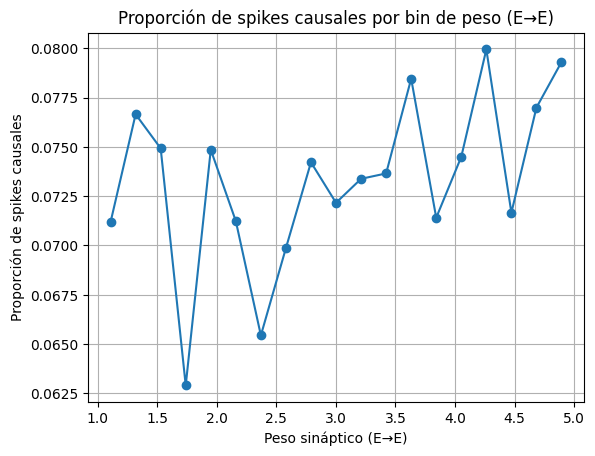

In [9]:
# Analizar la proporción de spikes causales por bin de peso

bins = np.linspace(df_causal['weight'].min(), df_causal['weight'].max(), 20)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Total de conexiones por bin de peso
i_arr = np.array(S.i)
j_arr = np.array(S.j)
w_arr = np.array(S.w)
total_by_bin = np.histogram(w_arr[w_arr > 0], bins=bins)[0]

# Spikes causales por bin de peso
causal_by_bin = np.histogram(df_causal['weight'], bins=bins)[0]

# Proporción causal por bin
proportion = causal_by_bin / (total_by_bin + 1e-9)  # evitar división por cero

plt.figure()
plt.plot(bin_centers, proportion, marker='o')
plt.xlabel('Peso sináptico (E→E)')
plt.ylabel('Proporción de spikes causales')
plt.title('Proporción de spikes causales por bin de peso (E→E)')
plt.grid(True)
plt.show()

In [10]:
pres_id = pick_neighbor(S, post_id, mode='random')

NameError: name 'pick_neighbor' is not defined

In [ ]:
pres_id, post_id

(958, 999)